In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
IMAGE_SIZE = 32
NUM_LABELS = 10
num_channels = 1 # grayscale

In [36]:
BATCH_SIZE = 1
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
NUM_HIDDEN = 128
SEED = 42

In [37]:
graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, num_channels))
    tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
    
    conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, num_channels, DEPTH_1], stddev=0.1))
    conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
    conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
    conv2_biases = tf.Variable(tf.zeros([DEPTH_2]))
    conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
    conv3_biases = tf.Variable(tf.zeros([DEPTH_3]))
    fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE//8 * IMAGE_SIZE//8 * DEPTH_3, NUM_HIDDEN], stddev=0.1))
    fc1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]))
    fc2_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    def model(data, train=False):
        conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        if train:
            hidden = tf.nn.dropout(hidden, 0.8, seed=SEED)
        return tf.matmul(hidden, fc2_weights) + fc2_biases
    
    def accuracy(predictions, labels):
        return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predictions, 1), labels), tf.float32)) * 100
    
    logits = model(tf_train_dataset, True)
    train_prediction = tf.nn.softmax(logits)
    train_accuracy = accuracy(train_prediction, tf_train_labels)


In [53]:
def gcn(dataset):
    """Global contrast normalization"""
    mean = dataset.mean(axis=(1,2))
    std = dataset.std(axis=(1,2))
    return (dataset - mean[:, None, None]) / std[:, None, None]

In [95]:
image = plt.imread('test-3-2.png')
image = image.mean(axis=2)
test_dataset = image.reshape((-1, 32, 32, 1))
test_dataset.shape

(1, 32, 32, 1)

In [96]:
test_dataset.shape

(1, 32, 32, 1)

In [97]:
test_dataset = gcn(test_dataset)

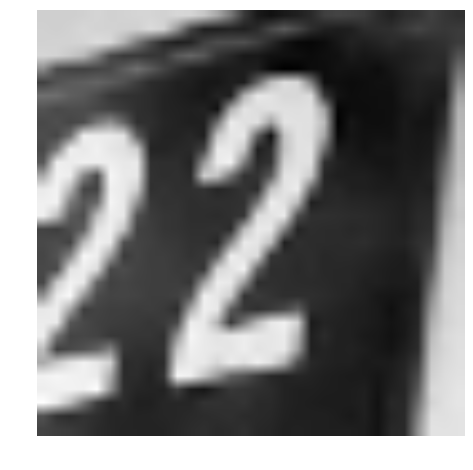

In [98]:
plt.axis('off')
plt.imshow(test_dataset[0].reshape((32,32)), cmap=plt.cm.gray)

In [99]:
with tf.Session(graph=graph) as session:
    saver.restore(session, 'single.ckpt')
    test_prediction = train_prediction.eval(feed_dict={tf_train_dataset: test_dataset})

In [100]:
test_prediction[0]

array([  4.46757156e-38,   0.00000000e+00,   1.00000000e+00,
         3.86693706e-30,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.19625181e-38,   5.72687271e-32,
         0.00000000e+00], dtype=float32)

In [101]:
import seaborn

<Container object of 10 artists>

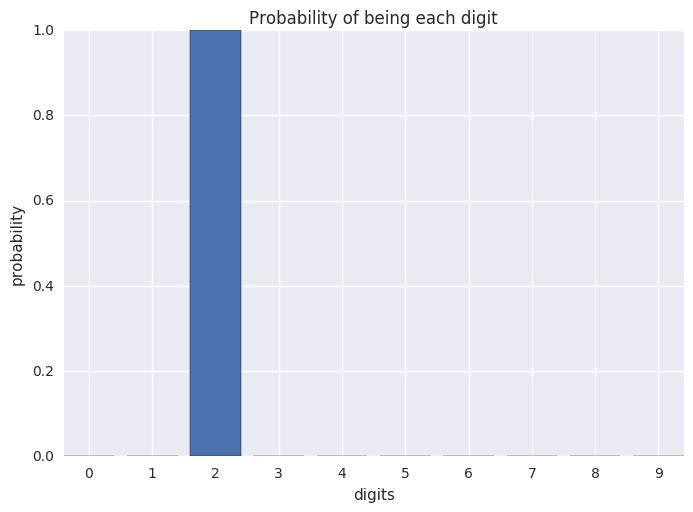

In [102]:
plt.title('Probability of being each digit')
plt.xticks(np.arange(10)+0.4, np.arange(10))
plt.ylabel('probability')
plt.xlabel('digits')
plt.bar(np.arange(10), test_prediction[0])